# **Identificador de jedi e sith**

## Autor:
#### Nome: João Gabriel Elvas Ribeiro
#### Matricula: 190109599
#### Github: JoaoGElvas

## Objetivo:
#### Conseguir distinguir um jedi de um sith.

## Preparando o ambiente: 
#### Primeiro iremos instalar o duckduckgo_search para podermos encontrar as URLS de imagens.
#### Após isso iremos instalar a biblioteca do fastai.

In [1]:
pip install -U duckduckgo_search

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install fastai

Note: you may need to restart the kernel to use updated packages.


## Obtendo as primeiras imagens 

#### Será utilizado o duckduckgo para encontrarmos as primeiras imagens

In [3]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term: str, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

#### Será utilizado o fastdownload para realizar o download de imagens.

In [4]:
urls = search_images('jedi', max_images=1)
urls[0]

Searching for 'jedi'


'http://images1.wikia.nocookie.net/__cb20100415021811/swgreatgalacticwarrpg/images/4/4f/Jedi_no_hood.jpg'

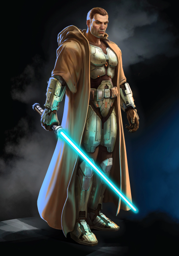

In [5]:
from fastdownload import download_url
dest = 'jedi.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

#### Temos nossa primeira imagem de jedi.

Searching for 'sith'


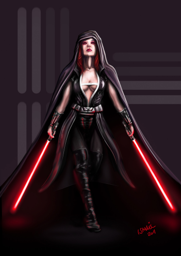

In [6]:
download_url(search_images('sith', max_images=1)[0], 'sith.jpg', show_progress=False)
Image.open('sith.jpg').to_thumb(256,256)

#### Temos nossa primeira imagem de sith.

#### A seguri iremos utilizar o código abaixo para realizar o dowload de alguns grupos de imagens para treinamento: 
* Foto de jedi
* Foto de jedi no sol
* Foto de jedi na sombra
* Foto de sith
* Foto de sith no sol
* Foto de sith na sombra

#### Obs: O comando *sleep(10)* é utilizado para gerar uma pausa entre as pesquisas, assim evitando sobrecarregar o servidor

In [7]:
searches = 'jedi','sith'
path = Path('jedi_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'jedi photo'
Searching for 'jedi sun photo'
Searching for 'jedi shade photo'
Searching for 'sith photo'
Searching for 'sith sun photo'
Searching for 'sith shade photo'


In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

7

#### Nessa etapa acima foi verificado se as imagens foram baixadas corretamente, as que apresentarem problemas serão excluídas.

#### A fim de desenvolver um modelo para realizar previsões, é preciso contar com os DataLoaders. DataLoaders são objetos que têm um conjunto de treinamento (imagens utilizadas para construir o modelo) e um conjunto de validação (imagens empregadas para avaliar a acurácia do modelo).

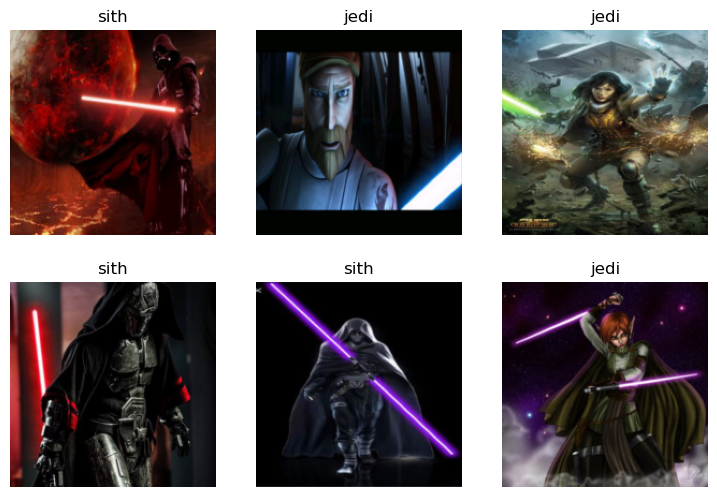

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

#### Parâmetros utilizados:

##### blocks: Como estamos utilizando imagens como inputs é neccesario utilizar o ImageBlocks. Já nossos outputs são categorias.

##### get-items: A função get_image_files é utilizada para encontrarmos os nossos inputs.

##### splitter: Com a finalidade de treinar melhor nosso programa vamos dividir os dades em treinamento e validação. O comando splitter tem essa função. Neste caso, estamos dividindo em 20% para validação e não serão usados dados no treinamento.

##### get_y: Utilizado para vincular cada imagem com um rotulo correspondente à pasta em que está localizada.

##### item_tfms: Essa operação irá redimensionar as imagens para 192 pixels, utilizando o método "squish". Que seria algo com esmagar a imagem.

## Treinando o modelo

#### Abaixo iremos treinar o modelo utilizando a função 'vision_learner'. A rede neural utilizada é a 'restnet18' pois foi a recomendada pelo professor na priemeira lissão do fastai. Logo após utilizamos o 'fine_tune', que utiliza modelos pré-treinados para melhorar o modelo já criado.

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.230418,2.040081,0.484848,00:16


epoch,train_loss,valid_loss,error_rate,time
0,0.607837,1.135175,0.333333,00:21
1,0.545197,0.884300,0.242424,00:24
2,0.418272,0.911300,0.303030,00:24
3,0.352594,0.968474,0.272727,00:24
4,0.303703,1.000040,0.303030,00:24


## Testando o modelo

#### Agora, iremos utilizar as imagens pré-selecionadas para testar a eficácia do nosso modelo.

Isso é: jedi.
Probabilidade de um jedi: 100.00%


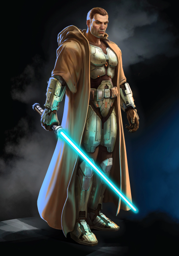

In [11]:
is_jedi,_,probs = learn.predict(PILImage.create('jedi.jpg'))
print(f"Isso é: {is_jedi}.")
print(f"Probabilidade de um {is_jedi}: {probs.sort()[0][-1]*100:.2f}%")
Image.open('jedi.jpg').to_thumb(256,256)

Isso é: sith.
Probabilidade de um sith: 99.90%


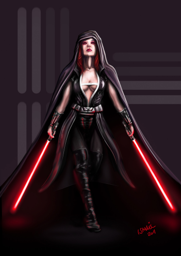

In [12]:
is_sith,_,probs = learn.predict(PILImage.create('sith.jpg'))
print(f"Isso é: {is_sith}.")
print(f"Probabilidade de um {is_sith}: {probs.sort()[0][-1]*100:.2f}%")
Image.open('sith.jpg').to_thumb(256,256)

In [13]:
learn.export('model.pkl')

## Deployment

Link do HuggingFace:https://huggingface.co/spaces/JoaoElvas/JedixSith

## Conclusão
Apesar de jedi e sith terem varias diferenças eles tambem tem varias caracteristicas em comum e a aplicação teve dificuldades de distinguir. Por isso nosso programa teve uma taxa de erro de 0.30. Mostrando que o programa tem uma taxa de erro expressiva.